<img align="center" src="./images/occiput_logo3.png" width="400">

# Zoomed PET  reconstruction 
This example of 3D PET reconstruction shows how to change the physical size and location of the reconstruction volume and of the attenuation map and their discretization grid (number of voxels). In this example we will first create activity and attenuation phantoms of given physical size and discretization grid and then reconstruct the activity in a volume of a different physical size and different number of voxels. We will then reconstruct with a smaller volume,  producing a zoomed high resolution reconstruction. 

In [1]:
import tomolab 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pet = tomolab.Reconstruction.PET_Static_Scan()

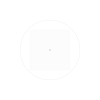

In [3]:
# Set dimensions of projection space (see Figure below): 
pet.binning.N_axial = 90
pet.binning.N_azimuthal = 11
pet.binning.N_u = 128
pet.binning.N_v = 128
pet.binning.size_u = 256
pet.binning.size_v = 256
pet.binning.angles_axial = np.linspace(0,np.pi,pet.binning.N_axial) #rad
pet.binning.angles_azimuthal = np.linspace(-0.5,0.5,pet.binning.N_azimuthal) #rad 
pet.set_binning(pet.binning)

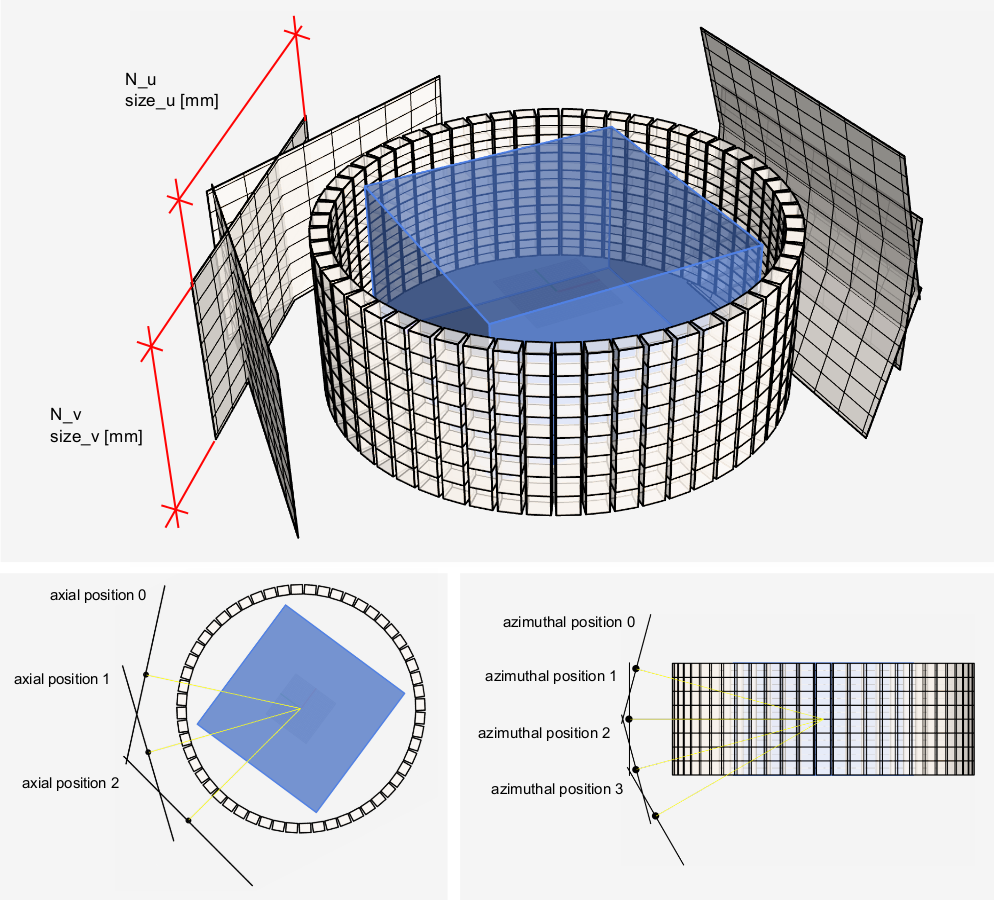

In [4]:
pet.binning.display_geometry()

In [5]:
# Let us create activity and attenuation phantoms with [128, 128, 128] voxels 
# and physical size [200.0 mm, 200.0 mm, 200.0 mm], then project them to obtain a simulation of a PET acquisition. 

phantom_activity_shape = [128,128,128]  #[voxels]
phantom_activity_size  = [200,200,200]  #[mm]
phantom_activity_center = [100,100,100] #[mm]

# Set dimensions of attenuation volume (it can be different from activity volume): 
phantom_attenuation_shape = [128,128,128]  #[voxels]
phantom_attenuation_size  = [200,200,200]  #[mm]

activity    = tomolab.DataSources.complex_phantom(
    shape = phantom_activity_shape,
    size  = phantom_activity_size,
    center=phantom_activity_center,
    radius=50,
    insert_radius=30,
    hole_radius=10,
    length=80,
    insert_length=50,
    insert_min_radius=5,
    insert_max_radius=12,
    insert_N_elems=6,
    inner_value=5.0,
    insert_value=5.0,
    outer_value=0.0,
    axis=2,
)

attenuation    = tomolab.DataSources.complex_phantom(
    shape = phantom_activity_shape,
    size  = phantom_activity_size,
    center=phantom_activity_center,
    radius=50,
    insert_radius=30,
    hole_radius=10,
    length=80,
    insert_length=50,
    insert_min_radius=5,
    insert_max_radius=12,
    insert_N_elems=6,
    inner_value=0.05,
    insert_value=0.05,
    outer_value=0.0,
    axis=2,
)
#uniform_cylinder(phantom_activity_shape,axis=2, inner_value=10.0, outer_value=0.00, radius=50)
#attenuation = tomolab.DataSources.uniform_cylinder(phantom_attenuation_shape,axis=2, inner_value=0.10, outer_value=0.00, radius=50)

pet.set_activity_size(phantom_activity_size)
pet.set_activity_shape(phantom_activity_shape)
pet.set_attenuation_size(phantom_attenuation_size)
pet.set_attenuation_shape(phantom_attenuation_shape)

pet.set_attenuation(attenuation)
projection = pet.project_activity(activity)

prompts = projection.copy()
prompts.apply_noise_Poisson()
pet.set_prompts(prompts)

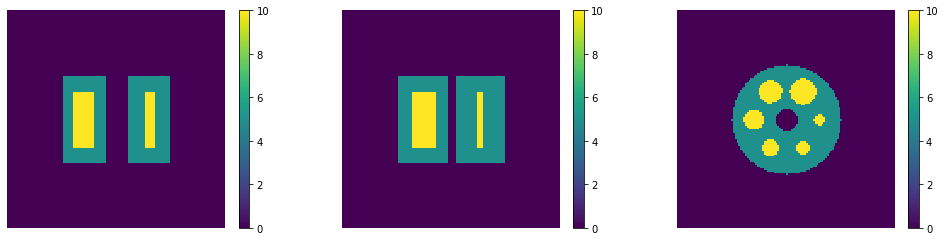

Activity shape: (128, 128, 128)


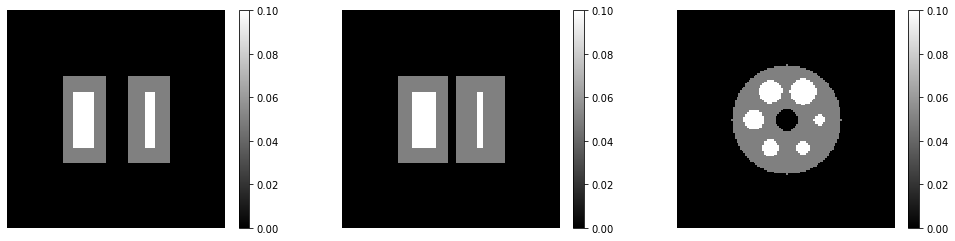

Attenuation shape: (128, 128, 128)


In [6]:
plt.figure(figsize=(17,4))
plt.subplot(1,3,1); plt.imshow(activity.data[:,63,:].T),plt.axis('off'),plt.colorbar()
plt.subplot(1,3,2); plt.imshow(activity.data[70,:,:].T),plt.axis('off'),plt.colorbar()
plt.subplot(1,3,3); plt.imshow(activity.data[:,:,70].T),plt.axis('off'),plt.colorbar()
plt.show()
print(f'Activity shape: {activity.shape}')

plt.figure(figsize=(17,4))
plt.subplot(1,3,1); plt.imshow(attenuation.data[:,63,:].T,cmap='gray'),plt.axis('off'),plt.colorbar()
plt.subplot(1,3,2); plt.imshow(attenuation.data[70,:,:].T,cmap='gray'),plt.axis('off'),plt.colorbar()
plt.subplot(1,3,3); plt.imshow(attenuation.data[:,:,70].T,cmap='gray'),plt.axis('off'),plt.colorbar()
plt.show()
print(f'Attenuation shape: {activity.shape}')

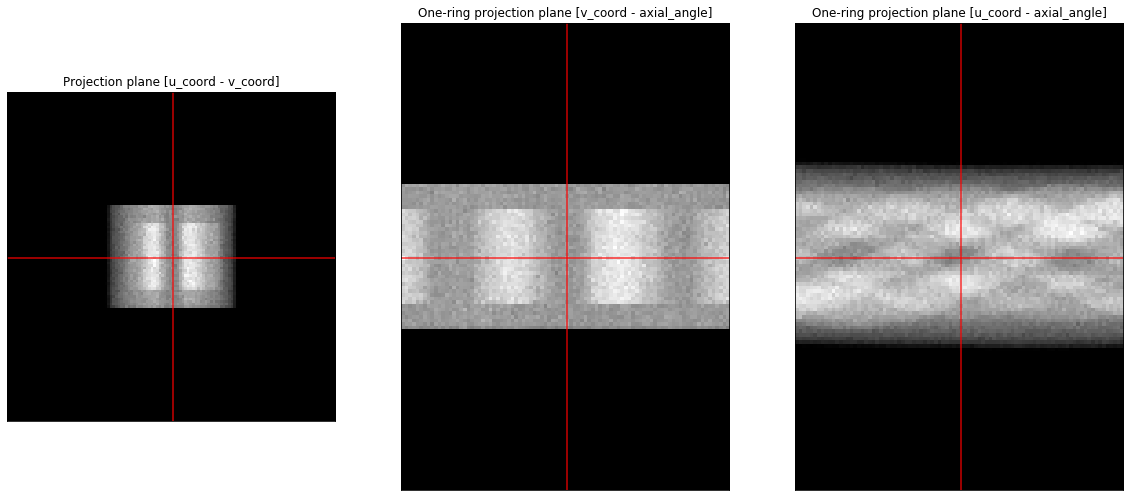

In [7]:
prompts.display(cmap = 'gray')

## Original FOV

In [8]:
# Let us now reconstruct the activity
print(pet.activity_shape)
print(pet.activity_size)
activity_recon = pet.osem_reconstruction(iterations=5, subset_number=10)

[128 128 128]
[200 200 200]
subset number: 10
subset size: 9
iterations tot: 50


FloatProgress(value=0.0, bar_style='info', description='OSEM Reconstruction', layout=Layout(border='solid 1px'…

Projecting attenuation
Done


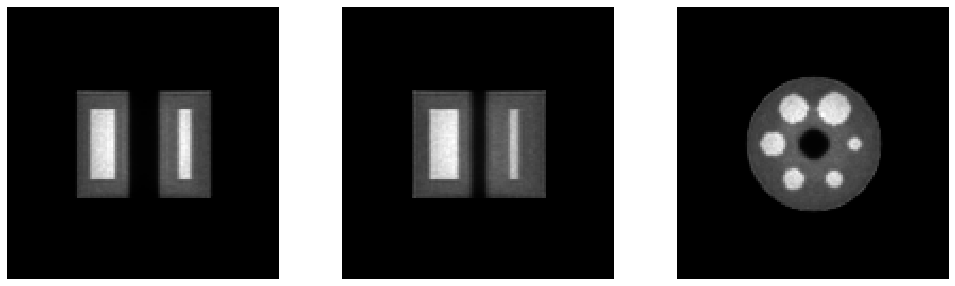

Activity shape: (128, 128, 128)
FOV (mm): [200 200 200]


In [9]:
plt.figure(figsize=(17,5))
plt.subplot(1,3,1); plt.imshow(activity_recon.data[:,63,:].T, cmap='gray'),plt.axis('off')
plt.subplot(1,3,2); plt.imshow(activity_recon.data[70,:,:].T, cmap='gray'),plt.axis('off')
plt.subplot(1,3,3); plt.imshow(activity_recon.data[:,:,70].T, cmap='gray'),plt.axis('off')
plt.show()
print(f'Activity shape: {activity_recon.shape}')
print(f'FOV (mm): {pet.activity_size}')

## Zoom IN (same image shape, but different FOV dim)

Let us now reconstruct the activity in volume with smaller physical size (FOV) and same number of voxels:
- This results in a **zoomed** reconstruction at the same computational cost. 

In [10]:
pet.set_activity_shape([128,128,128])
pet.set_activity_size( [120.0,120.0,120.0])
activity_zoomed = pet.osem_reconstruction(iterations=5, subset_number=10)

subset number: 10
subset size: 9
iterations tot: 50


FloatProgress(value=0.0, bar_style='info', description='OSEM Reconstruction', layout=Layout(border='solid 1px'…

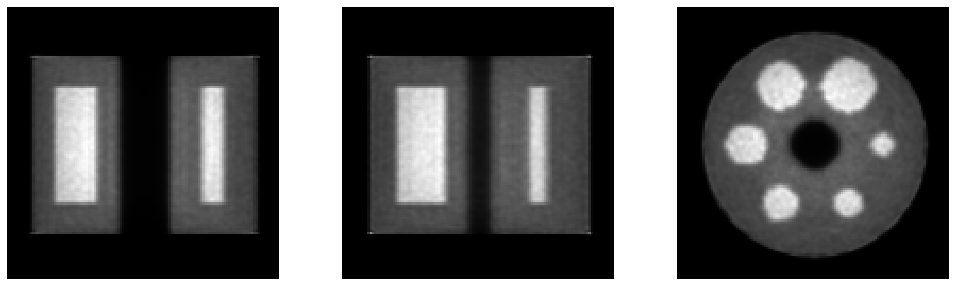

Activity shape: (128, 128, 128)
FOV (mm): [120. 120. 120.]


In [11]:
plt.figure(figsize=(17,5))
plt.subplot(1,3,1); plt.imshow(activity_zoomed.data[:,63,:].T, cmap='gray'),plt.axis('off')
plt.subplot(1,3,2); plt.imshow(activity_zoomed.data[75,:,:].T, cmap='gray'),plt.axis('off')
plt.subplot(1,3,3); plt.imshow(activity_zoomed.data[:,:,70].T, cmap='gray'),plt.axis('off')
plt.show()
print(f'Activity shape: {activity_zoomed.shape}')
print(f'FOV (mm): {pet.activity_size}')

## Resolution increase (same FOV size, with more pixels)

Let us now reconstruct the activity in volume with smaller physical size (FOV) than the original one, and with higher number of voxels:
- This results in a **zoomed**, high resolution reconstruction (***slower***). 
- Notice that the **attenuation volume has a different size and shape**. 
- The attenuation volume and activity volume can have arbitrary, independent physical size and shape. 


In [12]:
pet.set_activity_shape([256,256,256])
pet.set_activity_size([120.0,120.0,120.0])
activity_zoomed_hires = pet.osem_reconstruction(iterations=5, subset_number=10)

subset number: 10
subset size: 9
iterations tot: 50


FloatProgress(value=0.0, bar_style='info', description='OSEM Reconstruction', layout=Layout(border='solid 1px'…

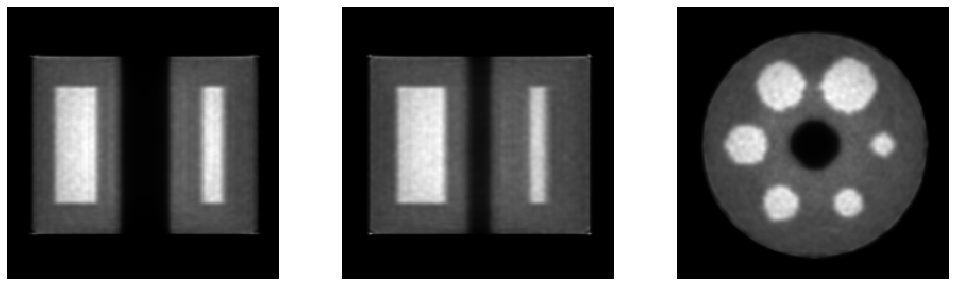

Activity shape: (256, 256, 256)
FOV (mm): [120. 120. 120.]


In [13]:
plt.figure(figsize=(17,5))
plt.subplot(1,3,1); plt.imshow(activity_zoomed_hires.data[:,126,:].T, cmap='gray'), plt.axis('off')
plt.subplot(1,3,2); plt.imshow(activity_zoomed_hires.data[150,:,:].T, cmap='gray'), plt.axis('off')
plt.subplot(1,3,3); plt.imshow(activity_zoomed_hires.data[:,:,140].T, cmap='gray'), plt.axis('off')
plt.show()
print(f'Activity shape: {activity_zoomed_hires.shape}')
print(f'FOV (mm): {pet.activity_size}')